<a href="https://colab.research.google.com/github/gborn/Whatsapp_Chat_Analysis/blob/main/notebooks/01_exploratory_data_analysis_on_whatsapp_chats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory Data Analysis
In this notebook, we conduct basic data wrangling, and EDA on a whatsapp group conversations. For this case study, we select a classroom whatsapp group of around 100 members. The group mostly discusses subjects related to AI/ML, and assignments.

<br>This notebook serves as groundwork for second notebook, where we perform extensive Topic modelling.

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import re

plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=False, dpi=100)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

sns.set()

## How does an exported whatsapp text file looks like?

In [46]:
!head -n 10 'exported_whatsapp_chat.txt'

21/07/2020, 22:22 - Messages and calls are end-to-end encrypted. No one outside of this chat, not even WhatsApp, can read or listen to them. Tap to learn more.
21/07/2020, 22:22 - Glad: hii tribhav..
21/07/2020, 22:22 - Tribhav: Hello
21/07/2020, 22:24 - Tribhav: <Media omitted>
21/07/2020, 22:27 - Glad: that's the perfect shape..
21/07/2020, 22:27 - Tribhav: 🤗
21/07/2020, 22:27 - Glad: hope I'm there one day..
21/07/2020, 22:27 - Tribhav: You'll
21/07/2020, 22:28 - Glad: far I've gone is oval.. that's why I like making naan.. no one will question me that way..
21/07/2020, 22:28 - Tribhav: Hahahah


Each line in exported text file has three distinct parts - date, and time of the message, and the message text. The file also contains notifications like 'Media omitted', or about encryption. We exclude these lines in our analysis.

## Preprocessing

In this section, we extract datetime, phone-number/name, and message text from each line, and generate a csv file with above three sections as header.

In [49]:
def separator(msg):
    """
    Function to read each line of .txt file, and extract date-time, name, and message text
    """
    msg = msg.strip()

    # we define three groups: datetime, person-name/phone number, message
    result = re.search(r'(\d{1,2}/\d{1,2}/\d{4},\s+\d{1,2}:\d{1,2})\s+-\s+([+0-9a-zA-Z\s]+):\s+(.*)', msg)

    # ignore lines that don't have above three groups, and return empty line
    if not hasattr(result, 'group'):
        return ''

    return result.groups()

separator('20/05/2021, 21:24 - +91 9999 99999: Check this ans https://stackoverflow.com/questions/41567895/will-scikit-learn-utilize-gpu')

('20/05/2021, 21:24',
 '+91 9999 99999',
 'Check this ans https://stackoverflow.com/questions/41567895/will-scikit-learn-utilize-gpu')

In [50]:
import csv
def txt_to_csv(fn):
    """
    Function to convert .txt file to csv file with three headers - datetime, id, message text
    Accepts `fn` filename of exported text file as argument
    """
    with open(fn) as f:
         lines = map(separator, f.readlines())

         with open(f'{fn[:-4]}.csv', 'w') as wf:
             out = csv.writer(wf)
             out.writerow(['datetime', 'id', 'message'])
             for line in lines:
                 if line:
                    out.writerow(line)

txt_to_csv('original_chats.txt')

To protect the privacy of the members, the phone numbers/real names have been masked with random names with a random-name-generator API. <b>This is done only for EDA and topic modelling notebooks, not in web app.</b>

In [44]:
!pip install getindianname > /dev/null
from getindianname import randname

# read the original data to mask the real ids.
chats = pd.read_csv('original_chats.csv')  # this dataset won't be available further

# get all unique real ids
real_ids = chats.id.unique().tolist()

# generate random names
generated_ids = [randname().split()[0] for _ in range(len(real_ids))]

# map each real id with a random name, and save the data
real_to_generated = dict(zip(real_ids, generated_ids))
chats['id'] = chats.id.map(real_to_generated)
chats.to_csv('group_chats.csv', index=False)

In [54]:
chats = pd.read_csv('group_chats.csv', parse_dates=['datetime'])
chats

,datetime,id,message
0,2021-10-05 11:16:00,Udaya,hi
1,2021-10-05 11:30:00,Udaya,Has anyone completed transfer learning assignm...
2,2021-10-05 11:30:00,Krishna,hi all
3,2021-10-05 16:11:00,Mahendra,<Media omitted>
4,2021-10-05 16:13:00,Sherya,df.age.isna() or df.age.isnull()
...,...,...,...
6315,2021-11-12 21:50:00,Raghvendra,Very nice article. 👏👏👏
6316,2021-11-12 23:44:00,Rohit,Anyone who is appearing or appeared for interv...
6317,2021-12-12 17:22:00,Sherya,Guys please anyone can share sample resume on ...
6318,2021-12-12 17:25:00,Ashish,Thank you :)


## How many unique members are in the whatsapp group?

In [55]:
chats.id.nunique()

136

## Who are the top active members?

In [70]:
# We can define active members as members who have higher percentage of contributions 
# to group messages
active_members = (
        (chats['id'].value_counts() / chats.shape[0]) # find percentage of messages sent
            .apply(lambda x: round(x, 2)) # round to two decimals
            .reset_index()
            .rename(columns={'index': 'user', 'id': 'Messages(%)'})
            .sort_values(by='Messages(%)', ascending=False)

    )

active_members.head(5)

,user,Messages(%)
0,Priyanka,0.07
2,Sherya,0.05
1,Nagaraju,0.05
3,Priyanshi,0.04
4,Namita,0.04


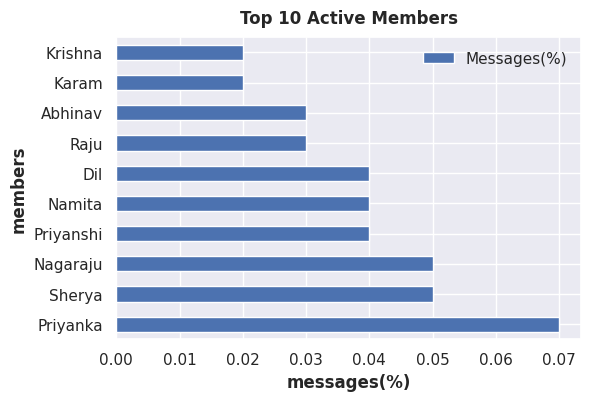

In [76]:
active_members[:10].plot(x='user', y='Messages(%)', kind='barh')
plt.title('Top 10 Active Members')
plt.xlabel('messages(%)')
plt.ylabel('members')
plt.show()

## When are the members of the group most active?

In [79]:
# To know when our members are most active, we can plot an activity heatmap

# we construct a period column for pretty printing of most active hours
df = chats.copy()
df['period'] = chats['datetime'].dt.hour.astype(str) + '-' + ((chats['datetime'].dt.hour + 1) % 24).astype(str)
pivot = df.pivot_table(
            index=chats['datetime'].dt.day_name(), 
            columns='period', 
            values='message', 
            aggfunc='count'
        ).fillna(0)

pivot

period,0-1,1-2,10-11,11-12,12-13,13-14,14-15,15-16,16-17,17-18,18-19,19-20,2-3,20-21,21-22,22-23,23-0,3-4,4-5,5-6,6-7,7-8,8-9,9-10
datetime,,,,,,,,,,,,,,,,,,,,,,,,
Friday,38.0,10.0,54.0,54.0,32.0,35.0,55.0,61.0,50.0,42.0,52.0,74.0,2.0,81.0,45.0,46.0,48.0,0.0,0.0,4.0,12.0,3.0,41.0,44.0
Monday,7.0,24.0,40.0,43.0,56.0,76.0,36.0,35.0,40.0,71.0,136.0,135.0,11.0,85.0,52.0,66.0,51.0,1.0,4.0,6.0,4.0,29.0,20.0,34.0
Saturday,10.0,28.0,33.0,50.0,69.0,36.0,55.0,30.0,43.0,63.0,55.0,91.0,1.0,48.0,71.0,8.0,21.0,3.0,0.0,0.0,7.0,20.0,9.0,52.0
Sunday,13.0,9.0,33.0,16.0,17.0,42.0,24.0,46.0,38.0,73.0,64.0,63.0,0.0,53.0,15.0,24.0,23.0,1.0,2.0,4.0,10.0,4.0,20.0,44.0
Thursday,22.0,39.0,22.0,34.0,47.0,39.0,53.0,37.0,91.0,65.0,67.0,60.0,17.0,106.0,45.0,60.0,45.0,0.0,4.0,4.0,12.0,24.0,22.0,35.0
Tuesday,17.0,14.0,59.0,48.0,120.0,98.0,53.0,59.0,67.0,52.0,140.0,70.0,2.0,99.0,76.0,121.0,62.0,2.0,4.0,3.0,17.0,5.0,33.0,19.0
Wednesday,33.0,4.0,36.0,34.0,37.0,55.0,30.0,49.0,23.0,34.0,84.0,39.0,0.0,77.0,61.0,71.0,39.0,1.0,1.0,5.0,2.0,4.0,6.0,19.0


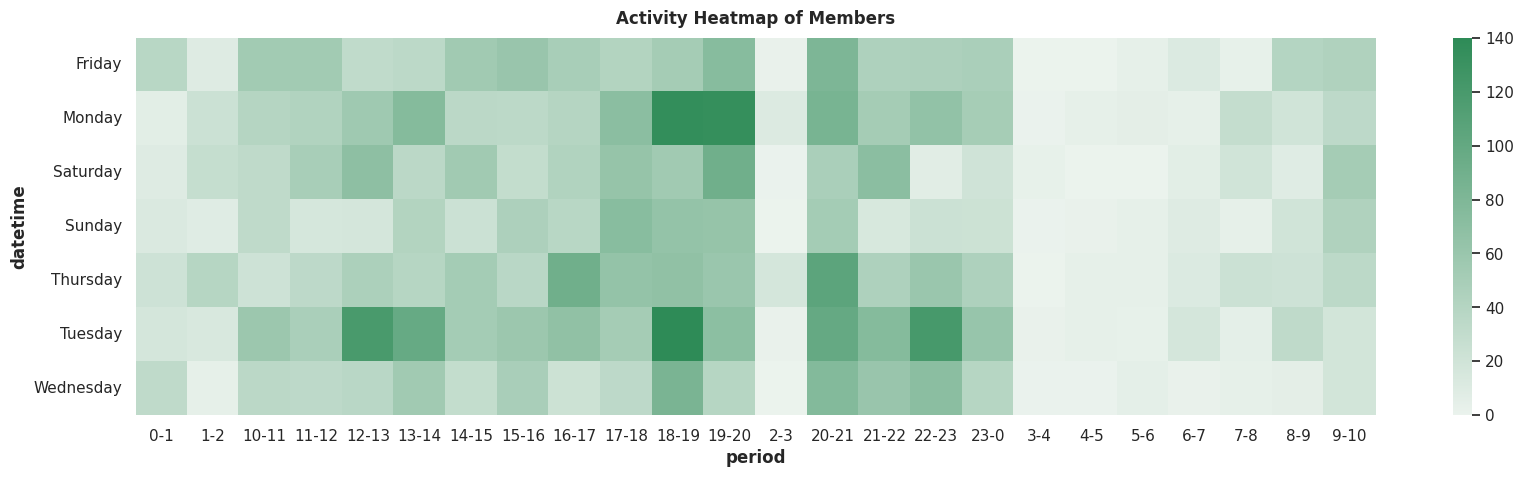

In [92]:
fig, ax = plt.subplots(figsize=(20, 5))
cm = sns.light_palette("seagreen", as_cmap=True)

sns.heatmap(pivot, cmap=cm, annot=False, ax=ax)
plt.title('Activity Heatmap of Members')
plt.show()

We can observe that members are most active after 6 pm in monday, and tuesday, and less active between 3 am to 7 am.

## What are most messages about?

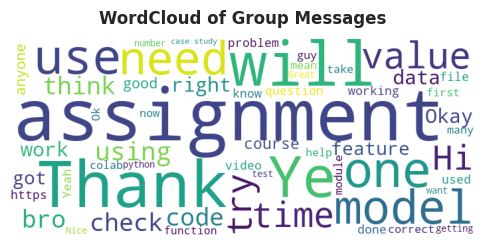

In [102]:
# To know what members most talk about, we can use a simple word cloud
#!pip install wordcloud > /dev/null
from wordcloud import WordCloud

df = chats.copy()

# remove messages about notifications or settings
df = df[df.message != '<Media omitted>']
df = df[df.message != 'This message was deleted']

def plot_wordcloud(messages, title):
    wc = WordCloud(width=700, height=300, min_font_size=12, background_color='white')
    wc = wc.generate(messages)
    fig, ax = plt.subplots()
    ax.imshow(wc)
    plt.axis('off')
    plt.title(title);

plot_wordcloud(df['message'].str.cat(sep=' '), 'WordCloud of Group Messages')

## What are the most used phrases in messages?

In [101]:
# we can refine the results one step further by removing stop words, and
# performing noun chunkings to get relevant nouns and verbs

# !pip install spacy > /dev/null
# !pip install emoji > /dev/null
import spacy
import emoji 
nlp = spacy.load('en')

# tokenize
tokens = [word for msg in df.message for word in msg.split()]
doc = nlp(' '.join(tokens))

# filter all tokens that arent stop words or punctuations
words = [token.text
        for token in doc
        if not token.is_stop and not token.is_punct]

# filter noun tokens that aren't stop words or punctuations
nouns = [token.text
        for token in doc
        if (not token.is_stop and
            not token.is_punct and
            token.pos_ == "NOUN")]

# filter verb tokens that aren't stop words or punctuations
verbs = [token.text
        for token in doc
        if (not token.is_stop and
            not token.is_punct and
            token.pos_ == "VERB")]

# filter emojis
emojis = [word for word in words if word in emoji.UNICODE_EMOJI['en']]

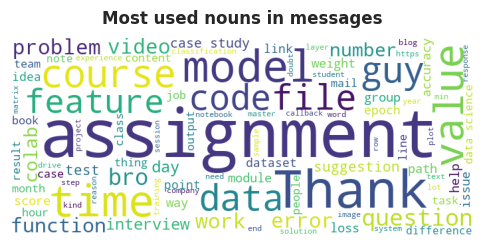

In [105]:
plot_wordcloud(' '.join(nouns), 'Most used nouns in messages')

Most members are talking about assignments, model, course, and code(this is a ML related classroom)

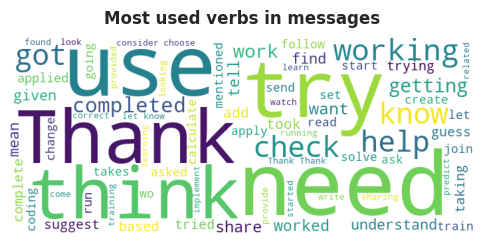

In [106]:
plot_wordcloud(' '.join(verbs), 'Most used verbs in messages')

Most used verbs in the messages are "Thank", "need", "working". We can conclude that most members are either asking for help related to their assignments, or helping out other members

## Which is the most preferred emoticon of group members?

In [115]:
from collections import Counter
table = Counter(emojis).most_common(10)
df = pd.DataFrame(table)
df = df.rename(columns={0:'emojis', 1:'count'})
# df.plot(x='emojis', y='count', kind='barh') # seaborn is unable to render emojis sadly

# pip install altair > /dev/null
import altair as alt
bar_chart = alt.Chart(df).mark_bar(
                    cornerRadiusTopLeft=3,
                    cornerRadiusTopRight=3,
            ).encode(
                    x=alt.X('count', axis=alt.Axis(title=None)),
                    y=alt.Y('emojis', axis=alt.Axis(title=None)),
                    color=alt.Color('count', legend=None),
            )

text = bar_chart.mark_text(
            align='center',
            dx=9,
            color='white'
            ).encode(
            text='count'
        )
            

bar_chart + text

alt.LayerChart(...)

Most prefered emoji is a thumbs up 👍



## How did emoticons evolve over time?

<br> As per this [research](), how emojis evolved over time in a conversation can signify how the relationship evolved between the two persons. This is a more helpful visualization for one-to-one conversations.

In [121]:
# pip install plotly > /dev/null
from plotly import graph_objects as go
df = chats.copy()
df.set_index('datetime', inplace=True)

# Get emojis in each message, 
df_emojis = df['message'].apply(lambda lst:[x if x in emoji.UNICODE_EMOJI['en'] else -1 for x in lst][0])
df_emojis = df[df_emojis!=-1]

df_emojis = df_emojis['message'].resample('M').apply(pd.Series.mode).reset_index(level=['datetime'])

# timeline of messages
yearly_timeline = df.resample('M')['message'].count().reset_index()
yearly_text = df.resample('M')['message'].apply(pd.Series.mode).tolist()

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=yearly_timeline['datetime'], 
    y=yearly_timeline['message'],
    hovertemplate =
    '<b>%{y:.2s} messages</b>: '+
    '<br><i>%{text}</i>',
    text = yearly_text,
))

fig.add_trace(go.Bar(
    x=yearly_timeline['datetime'], 
    y=yearly_timeline['message'],
    hovertemplate="%{y:.2s}",
    marker=dict(color=yearly_timeline['message'], colorbar=None),
))

fig.update_layout(
                    title='Timeline of Emoticons with messages',
                    yaxis= go.layout.YAxis(title="Total Messages"),
                    showlegend=False,
                    xaxis = go.layout.XAxis(title='Months', tickangle=45),
                    xaxis_tickformat = '%B<br>%Y',
                    autosize=False,
                    height=500,
                )

fig.update_xaxes(
    rangeslider_visible=True,
    )


fig.add_trace(go.Scatter(
    x=df_emojis['datetime'], 
    y=yearly_timeline.set_index('datetime').loc[df_emojis.datetime, 'message'],
    text=df_emojis['message'].tolist(),
    mode="markers+text",
    name='',
))

fig

We observe that preferred emoticon of members has stayed the same over the time.